In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

In [74]:
df = pd.read_parquet(r"C:\Users\Lenovo\Volatility-Options-Trading\data\AAPL_20y_returns.parquet")

In [75]:
df.shape

(4931, 12)

In [ ]:
returns=df['log_return'].dropna()


4930

In [77]:
df['returns'].isna().sum()

1

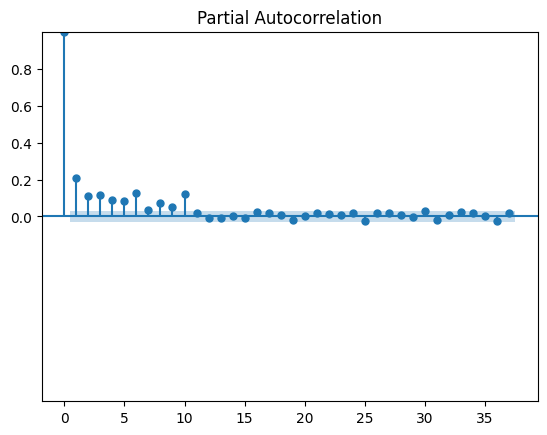

In [79]:
plot_pacf(returns**2)
plt.yticks(np.arange(0, 1,0.20))
plt.show()


In [67]:
# Fit GARCH model
model = arch_model(returns, p=1, q=1)
res = model.fit()

res.summary()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.4641965376465566e+21
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.3754469333746736e+17
Iteration:      3,   Func. Count:     32,   Neg. LLF: -12804.579039589762
Optimization terminated successfully    (Exit mode 0)
            Current function value: -12804.579025140882
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 3


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000406. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                12804.6
Distribution:                  Normal   AIC:                          -25601.2
Method:            Maximum Likelihood   BIC:                          -25575.1
                                        No. Observations:                 4931
Date:                Sat, Aug 09 2025   Df Residuals:                     4930
Time:                        15:18:48   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.7113e-03  1.147e-06   1491.599      0.000 [1.709e-03,1.714e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      8.1198e-06  6.411e-11  1.266e+05      0.000 [8.120e-06,8.120e-06]
alpha[1]       0.1000  1.649e-02      6.064  1.330e-09   [6.768e-02,  0.132]
beta[1]        0.8800  1.441e-02     61.054      0.000     [  0.852,  0.908]
============================================================================

Covariance estimator: robust
"""

In [80]:
from arch import arch_model
import pandas as pd
import numpy as np

rolling_predictions = []
test_size = 252 * 19  

for i in range(test_size):
    # Use all data up to the forecast point
    train = returns[:-(test_size - i)]
    
    model = arch_model(train, p=2, q=2, mean='Constant', vol='GARCH', dist='normal')
    model_fit = model.fit(disp='off')
    
    # Forecast 1-step ahead volatility
    pred = model_fit.forecast(horizon=1)
    vol_forecast = np.sqrt(pred.variance.values[-1, :][0])
    
    rolling_predictions.append(vol_forecast)

# Align predictions with correct dates (last `test_size` dates)
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-test_size:])


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007453. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007486. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Lenov

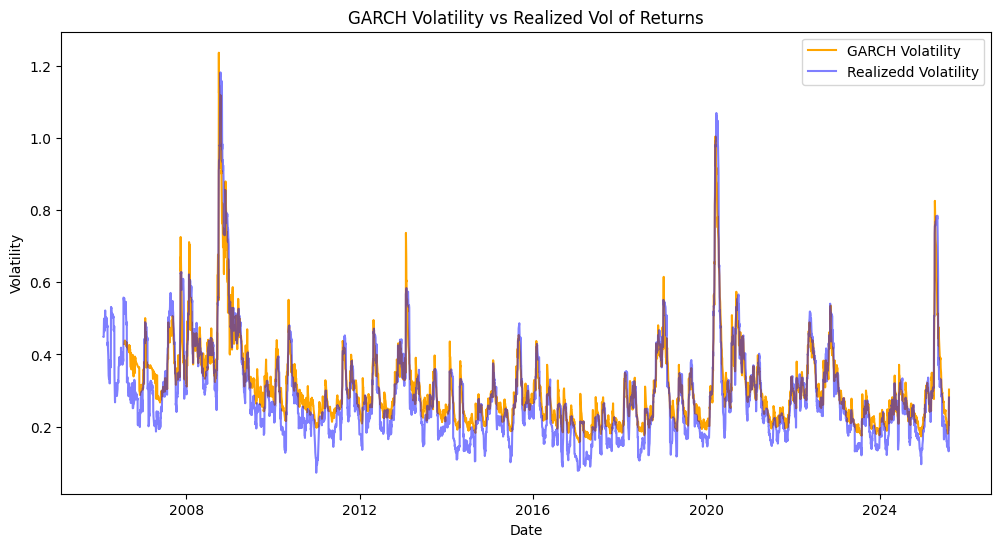

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(rolling_predictions*np.sqrt(252), label='GARCH Volatility', color='orange')
plt.plot(df['rolling_vol'], label='Realizedd Volatility', alpha=0.5, color='blue')
plt.title('GARCH Volatility vs Realized Vol of Returns')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


In [82]:
#Accuracy Check



# Assuming your variables are named like this:
# garch_vol -> GARCH predicted vol
# realized_vol -> Realized volatility (same index as garch_vol)

# Drop NaN alignment issues
aligned = pd.concat([rolling_predictions, df['rolling_vol']], axis=1).dropna()
garch_vol_aligned = aligned.iloc[:, 0]
realized_vol_aligned = aligned.iloc[:, 1]

# Correlation
correlation = garch_vol_aligned.corr(realized_vol_aligned)

# Mean Squared Error
mse = mean_squared_error(realized_vol_aligned, garch_vol_aligned)

print(f"Correlation: {correlation:.4f}")
print(f"MSE: {mse:.6f}")

Correlation: 0.9455
MSE: 0.087772
